# Testing VAMPNets on the Ordered MNIST example

In [1]:
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

In [2]:
#Data pipeline
from datasets import load_from_disk
ordered_MNIST = load_from_disk('__data__')
#Creating a copy of the dataset in numpy format
np_ordered_MNIST = ordered_MNIST.with_format(type='numpy', columns=['image', 'label'])

In [3]:
import torch.nn as nn
import torch

#Setting up the architecture
class CNNEncoder(nn.Module):
    def __init__(self, num_classes):
        super(CNNEncoder, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output num_classes classes
        self.out = nn.Sequential(
            nn.Linear(32 * 7 * 7, num_classes)
        )  
        torch.nn.init.orthogonal_(self.out[0].weight)      
    def forward(self, x):
        if x.dim() == 3:
            x = x.unsqueeze(1) # add channel dimension if needed
            
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output

In [4]:
import logging
import os
import lightning
import numpy as np
from pathlib import Path
import pickle
from kooplearn.abc import TrainableFeatureMap
from typing import Optional

#Following kooplearn implementations, we define a Pytorch Lightning module
class ClassifierModule(lightning.LightningModule):
    def __init__(self, num_classes: int, learning_rate: float):
        super().__init__()
        self.num_classes = num_classes
        self.encoder = CNNEncoder(num_classes=num_classes)
        self.learning_rate = learning_rate
        self.loss_fn = torch.nn.CrossEntropyLoss()

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr = self.learning_rate)
        return optimizer
    
    def training_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)               
        loss = self.loss_fn(output, labels)
        with torch.no_grad():
            pred_labels = output.argmax(dim=1)
            accuracy = (pred_labels == labels).float().mean()
        return {'loss': loss, 'accuracy': accuracy}
    
    def validation_step(self, batch, batch_idx):
        images, labels = batch['image'], batch['label']
        output = self.encoder(images)  
        pred_labels = output.argmax(dim=1)
        accuracy = (pred_labels == labels).float().mean() # Scalar
        return {'accuracy': accuracy}
    
class ClassifierFeatureMap(TrainableFeatureMap):
    def __init__(
                self, 
                num_classes: int,
                learning_rate: float,
                trainer_kwargs: dict,
                seed: Optional[int] = None  
                ):
        #Set rng seed
        lightning.seed_everything(seed)
        self.seed = seed
        self._lightning_module = ClassifierModule(num_classes, learning_rate)
        
        #Init trainer
        self.trainer = lightning.Trainer(**trainer_kwargs)
        
        self._storage = {
            'num_classes': num_classes,
            'learning_rate': learning_rate,
            'trainer_kwargs': trainer_kwargs,
            'seed': seed
        }
        self._trainer_kwargs = trainer_kwargs
        self._is_fitted = False
        
    @property
    def is_fitted(self) -> bool:
        return self._is_fitted
    
    @property
    def lookback_len(self) -> int:
        return 1 #Hardcoding it here, as we are not using lookback windows
    
    def save(self, path: os.PathLike):
        path = Path(path)
        path.mkdir(parents=True, exist_ok=True)
        ckpt = path / 'weights.ckpt'
        params = path / 'params.pkl'
        self.trainer.save_checkpoint(str(ckpt))
        self._storage['is_fitted'] = self._is_fitted
        with open(params, 'wb') as f:
            pickle.dump(self._storage, f)

    @classmethod
    def load(cls, path: os.PathLike):
        with open(Path(path) / 'params.pkl', 'rb') as f:
            storage = pickle.load(f)
        _is_fitted = storage.pop('is_fitted')
        feature_map = cls(**storage)
        feature_map._is_fitted = _is_fitted
        ckpt = Path(path) / 'weights.ckpt'
        feature_map._lightning_module = ClassifierModule.load_from_checkpoint(str(ckpt))
        return feature_map

    def fit(self, **trainer_fit_kwargs: dict):
        if 'model' in trainer_fit_kwargs:
            logging.warn("The 'model' keyword should not be specified in trainer_fit_kwargs. The model is automatically set to the DPNet feature map, and the provided model is ignored.")
            trainer_fit_kwargs = trainer_fit_kwargs.copy()
            del trainer_fit_kwargs['model']
        self.trainer.fit(model=self._lightning_module, **trainer_fit_kwargs)
        self._is_fitted = True

    def __call__(self, X: np.ndarray) -> np.ndarray:
        X = torch.from_numpy(X).float()
        X.to(self._lightning_module.device)
        self._lightning_module.eval()
        with torch.no_grad():
            embedded_X = self._lightning_module.encoder(X)
            embedded_X = embedded_X.detach().numpy()
        return embedded_X

In [5]:
from torch.utils.data import DataLoader
train_dl = DataLoader(ordered_MNIST['train'], batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(ordered_MNIST['validation'], batch_size=len(ordered_MNIST['validation']), shuffle=False)

#Metrics Logging
from lightning.pytorch.callbacks import Callback
class MetricsCallback(Callback):
    def __init__(self):
        super().__init__()
        self.train_acc = []
        self.train_steps = []
        self.val_acc = []
        self.val_steps = []

    def on_train_batch_end(self, trainer, pl_module, outputs, batch, batch_idx):
        # Get the metrics from the last training step
        self.train_acc.append(outputs['accuracy'].item())
        self.train_steps.append(trainer.global_step)
    def on_validation_batch_end(self, trainer, pl_module, outputs, batch, batch_idx, dataloader_idx = 0):
        # Get the metrics from the last validation step
        self.val_acc.append(outputs['accuracy'].item())
        self.val_steps.append(trainer.global_step)
        
metrics = MetricsCallback()
trainer_kwargs = {
    'accelerator': 'gpu',
    'max_epochs': 20,
    'log_every_n_steps': None,
    'callbacks': [metrics],
    'enable_progress_bar': True,
    'devices': 1
}

oracle = ClassifierFeatureMap(
    configs.classes,
    1e-2,
    trainer_kwargs, 
    seed=configs.rng_seed
)

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*") #Ignore warnings about num_workers

oracle.fit(train_dataloaders=train_dl, val_dataloaders=val_dl)

Global seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
  warning_cache.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type             | Params
---------------------------------------------
0 | encoder | CNNEncoder       | 21.1 K
1 | loss_fn | CrossEntropyLoss | 0     
-----------------------------

Sanity Checking: 0it [00:00, ?it/s]

/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:281: PossibleUserWarning: The number of training batches (7) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


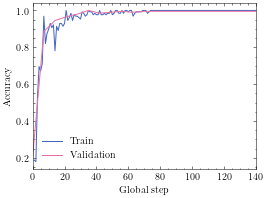

In [7]:
#Checking the data
import matplotlib.pyplot as plt
import scienceplots #Nicer styles
plt.style.use(['science', 'retro'])
plt.rcParams['figure.dpi'] = 72

fig, ax = plt.subplots(1, 1, figsize=(4, 3))
ax.plot(metrics.train_steps, metrics.train_acc, label='Train')
ax.plot(metrics.val_steps, metrics.val_acc, label='Validation')
ax.set_xlabel('Global step')
ax.set_ylabel('Accuracy')
ax.legend(frameon=False)
ax.margins(x=0)

In [8]:
import kooplearn.abc
def evaluate_model(model: kooplearn.abc.BaseModel, test_data):
    assert model.is_fitted
    test_labels = test_data['label']
    test_images = test_data['image']
    test_images = np.expand_dims(test_images, 1)
    report = {
        'accuracy': [],
        'label': [],
        'image': [],
        'times': []
    }
    for t in range(1, configs.eval_up_to_t + 1):
        pred = model.predict(test_images, t=t).reshape(-1, 28 ,28)
        pred_labels = oracle(pred)
        pred_labels = pred_labels.argmax(axis=1)
        accuracy = (pred_labels == (test_labels + t)%configs.classes ).mean()
        report['accuracy'].append(accuracy)
        report['image'].append(pred)
        report['label'].append(pred_labels)
        report['times'].append(t)
    return report

In [10]:
from kooplearn._src.context_window_utils import trajectory_to_contexts

context_len = 2
train_data = trajectory_to_contexts(np_ordered_MNIST['train']['image'], context_len)
val_data = trajectory_to_contexts(np_ordered_MNIST['validation']['image'], context_len)

In [12]:
#Preparing data loaders
from torch.utils.data import Dataset

class ContextWindowDataset(Dataset):
    #Minimal Torch dataset to handle context windows. TODO: Add to kooplearn
    def __init__(self, contexts):
        self.contexts = contexts
    def __len__(self):
        return len(self.contexts)
    def __getitem__(self, idx):
        return self.contexts[idx]

train_ds = ContextWindowDataset(torch.from_numpy(train_data.copy()))
val_ds = ContextWindowDataset(torch.from_numpy(val_data.copy()))

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

In [13]:
from kooplearn.models.feature_maps.vampnets import VAMPNet

Things to do:
1. Defining the `lightning` trainer
2. Tensorboard logging through callbacks
3. 

In [ ]:
#Defining the lightning trainer